In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from IPython.display import display
from matplotlib import ticker
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Reshape, Input, Dense, Flatten, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

### Константы для путей к файлам

In [2]:
# Пути к обработанным данным
# Пути к X части выборки с массивами в каждой ячейке
path_to_array_like_X_data = ('data/Prepared data/Run1/X_data_array_like.xlsx',
                             'data/Prepared data/Run2/X_data_array_like.xlsx')
# Пути к Y части выборки
path_to_Y_data = ('data/Prepared data/Run1/Y_data(binary_classification).xlsx', 
                  'data/Prepared data/Run2/Y_data(binary_classification).xlsx') 


### Константы для обработки данных

In [3]:
PREP_image_size = 48

In [4]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

In [5]:
def to_list_of_64_values(x):
  # делим начальную строку на пары чисел
  # пары чисел тут - это просто строки
  x = str(x[1:-1]).split(',')
  x = np.array(x)

  x = x.astype(float)
  
  return x

In [6]:
# прочесть файл X_data_array-like.xlsx
def get_array_like_X_df(path: str):
    df = pd.read_excel(path,index_col=[0])
    df = df.apply(lambda x: 
                  x.apply(to_list_of_64_values, convert_dtype=True))
    return df

In [7]:
# прочесть файл Y_data(binary_classification).xlsx
def get_Y_df(path: str):
    df = pd.read_excel(path,index_col=[0])
    return df

In [8]:
# кропы массива pandas имеют размер (PREP_image_size, PREP_image_size)
# после преобразования в numpy через to_numpy() размер тот-же,
# при том, что в каждой ячейке хранится массив из 64 чисел как объект
# для работы нужно преобразовать кроп к размеру (PREP_image_size, PREP_image_size, 64)
# чтобы каждый элемент массива был не объектом, а вещественным числом
def pandas_crop_to_image_like_numpy(df):
    x = df.to_numpy()
    return np.stack([np.stack([x[i,j] for i in range(x.shape[0])],axis=0) for j in range(x.shape[1])],axis=1)

In [9]:
# приведение к виду, который принимают на вход слои Conv2D
# (batch, channels, rows, cols) если data_format='channels_first'
# (batch, rows, cols, channels) если data_format='channels_last'
# тут выбран последний формат 
# а так как "изображения" состоят из 64 измерений, то 
# каналов либо 64, либо по 32
def reshape_X_df_to_image_like_numpy(df, crop_size):
    #rows_count = df.shape[0] - df.shape[0] % PREP_image_size
    #cols_count = df.shape[1] - df.shape[1] % PREP_image_size
    
    print('||||||||||||||||||')
    print('X df reshaping to 4D')
    print('Original df size: ', df.shape)
    print('Crop windows height/width: ', crop_size)
    #print('New df size (если одна из размерностей не делится нацело на размер окна crop): ', (rows_count,cols_count))
    
    # тестовое. Обработка одного столбца датафрейма
    '''temp = np.stack(
        [pandas_crop_to_image_like_numpy(
            df.iloc[i:i+PREP_image_size,0:PREP_image_size]) 
             for i in range(0,rows_count,PREP_image_size)]
                ,axis=0)'''
    
    temp = np.concatenate([np.stack(
        [pandas_crop_to_image_like_numpy(
            df.iloc[i:i+crop_size,j:j+crop_size]) 
             for i in range(0,df.shape[0],crop_size)]
                , axis=0) for j in range(0,df.shape[1],crop_size)]
                    , axis=0)
    
    # поделим x выборку на значения времен и амплитуд
    X_time = temp[:,:,:,:32]
    X_amp = temp[:,:,:,32:]
    
    print('New X_time shape: ', X_time.shape)
    print('New X_amp shape: ', X_amp.shape)
    print('||||||||||||||||||\n')
    
    return (X_time,X_amp)

In [10]:
# приведение к нужному виду бинарных масок
def reshape_Y_df_to_image_like_numpy(df, crop_size):
    #rows_count = df.shape[0] - df.shape[0] % PREP_image_size
    #cols_count = df.shape[1] - df.shape[1] % PREP_image_size
    
    print('||||||||||||||||||')
    print('Y df reshaping to 3D')
    print('Original df size: ', df.shape)
    print('Crop windows height/width: ', crop_size)
    #print('New df size (если одна из размерностей\n не делится нацело на размер окна crop): ', (rows_count,cols_count))
    
    
    Y_res = np.concatenate([np.stack(
        [df.iloc[i:i+crop_size,j:j+crop_size].to_numpy().astype('float32') 
             for i in range(0,df.shape[0],crop_size)]
                , axis=0) for j in range(0,df.shape[1],crop_size)]
                    , axis=0)
    
    
    Y_res = np.expand_dims(Y_res,axis=3)
    
    print('New numpy shape: ', Y_res.shape)
    print('||||||||||||||||||\n')
    
    return Y_res

In [11]:
# преобразовать массив кропов numpy Y выборки размера (batch,rows,cols) 
# в матрицу размера (rows,cols)
def reshape_3D_Y_numpy_to_2D(arr, rows_count, cols_count, crop_size):
    
    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Original arr size: ', arr.shape)
    print('Crop windows height/width: ', crop_size)
    
    crops_per_rows_count = int(rows_count/crop_size) # кол-во строк / размер кропа
    crops_per_cols_count = int(cols_count/crop_size) # кол-во столбцов / размер кропа
    
    temp  = np.concatenate([
                np.concatenate([arr[i + (j*crops_per_rows_count)] 
                             for i in range(crops_per_rows_count)],axis=0)
                                 for j in range(crops_per_cols_count)],axis=1)
    
    print('New numpy shape: ', temp.shape)
    print('||||||||||||||||||\n')
    
    return temp

In [12]:
# вернет бинарную 1D маску, где 1 - для кропов с дефектами
# 0 - для кропов без дефектов
def calculate_crops_with_defects_positions(Y_arr, crop_size):
    
    print('||||||||||||||||||')
    print('Defects nums calculating')
    # Найдем на каких картинках есть дефекты
    defects_nums = list()
    for i in range(Y_arr.shape[0]):
        if np.sum(Y_arr[i] > 0) >= 1:
            defects_nums.append(True)
        else:
            defects_nums.append(False)

    defects_nums = np.array(defects_nums, dtype='bool')

    print(f'Для карт высотой и шириной в {crop_size}',
          f'и общим кличеством: {Y_arr.shape[0]}',
            f'дефекты присутствуеют на {np.sum(defects_nums)} картах',
              sep='\n')
    print('||||||||||||||||||\n')
    
    return defects_nums


In [13]:
def preprocess_data(X_time_arr, X_amp_arr, Y_arr, crop_size, X_time_max=0, X_amp_max=0):
    # стндартизуем данные
    # удалим кропы, в которых нет дефектов
    
    print('||||||||||||||||||')
    print('Data preprocessing')
    
    print('Orig X_time_arr shape: ', X_time_arr.shape)
    print('Orig X_amp_arr shape: ', X_amp_arr.shape)
    print('Orig Y_arr shape: ', Y_arr.shape)
    
    
    print('||||||||||||||||||')
    print('Data standartization')
    
    # стандартизуем данные
    if ((X_time_max == 0) and (X_amp_max == 0)):
        X_time_max = X_time_arr.max()
        X_amp_max = X_amp_arr.max()

    print(f'X_time_max: {X_time_max}')
    print(f'X_amp_max: {X_amp_max}')

    X_time_arr = X_time_arr / X_time_max
    X_amp_arr = X_amp_arr / X_amp_max
    
    print(f'X_time_max after standartization: {X_time_arr.max()}')
    print(f'X_time_min after standartization: {X_time_arr.min()}')
    
    print(f'X_amp_max after standartization: {X_amp_arr.max()}')
    print(f'X_amp_min after standartization: {X_amp_arr.min()}')
    
    print('||||||||||||||||||\n')
    
    print('||||||||||||||||||')
    print('Data with and witout defects splitting')
    
    # удалим кропы не содержищие дефекты
    defects_nums = calculate_crops_with_defects_positions(Y_arr, crop_size)
    
    X_time_arr_def = X_time_arr[defects_nums]
    X_amp_arr_def = X_amp_arr[defects_nums]
    Y_arr_def = Y_arr[defects_nums]
    
    X_time_arr_non_def = X_time_arr[~defects_nums]
    X_amp_arr_non_def = X_amp_arr[~defects_nums]
    Y_arr_non_def = Y_arr[~defects_nums]
    
    print('X_time_arr_def shape: ', X_time_arr_def.shape)
    print('X_time_arr_non_def shape: ', X_time_arr_non_def.shape)
    
    print('X_amp_arr_def shape: ', X_amp_arr_def.shape)
    print('X_amp_arr_non_def shape: ', X_amp_arr_non_def.shape)
    
    print('Y_arr_def shape: ', Y_arr_def.shape)
    print('Y_arr_non_def shape: ', Y_arr_non_def.shape)
    print('||||||||||||||||||\n')
    print('||||||||||||||||||\n')
    
    return (X_time_arr_def,X_time_arr_non_def),(X_amp_arr_def,X_amp_arr_non_def),(Y_arr_def,Y_arr_non_def)

In [14]:
# датафрейм размера 112 на 400 при размере кропа в 10
# преобразует в размер 120 на 400 (чтобы каждая сторона ровно
# делилась на размер кропа)
# новые строки добавляются за счет копирования старых
def reshape_df_for_future_crops(df, crop_size):
    
    print('||||||||||||||||||')
    print('Df reshaping for exact splitting with crop_size')
    print('Original df size: ', df.shape)
    print('Crop windows height/width: ', crop_size)
    
    if (df.shape[0] % crop_size != 0):
      new_rows = crop_size - (df.shape[0] % crop_size)
      df = pd.concat([df,df.iloc[-1:-new_rows-1:-1]],axis=0,ignore_index=True)
    
    if (df.shape[1] % crop_size != 0):
      new_cols = crop_size - (df.shape[1] % crop_size)
      df = pd.concat([df,df.iloc[:,-1:-new_cols-1:-1]],axis=1,ignore_index=True)

    print('New df shape: ', df.shape)
    print('||||||||||||||||||\n')
    
    return df

In [15]:
# применить аугментации к данным
# повернуть каждую картинку на 90 градусов 3 раза как пример
# для увеличения кол-ва данных для обучения
def augment_data(X_time_arr, X_amp_arr, Y_arr):
    print('||||||||||||||||||')
    print('Data augmentation')
    
    print('Orig X_time_arr shape: ', X_time_arr.shape)
    print('Orig X_amp_arr shape: ', X_amp_arr.shape)
    print('Orig Y_arr shape: ', Y_arr.shape)
    
    X_time_arr = np.concatenate([X_time_arr,
                            np.rot90(X_time_arr,1,[1,2]),
                            np.rot90(X_time_arr,2,[1,2]),
                            np.rot90(X_time_arr,3,[1,2])],axis=0)

    X_amp_arr = np.concatenate([X_amp_arr,
                            np.rot90(X_amp_arr,1,[1,2]),
                            np.rot90(X_amp_arr,2,[1,2]),
                            np.rot90(X_amp_arr,3,[1,2])],axis=0)

    Y_arr = np.concatenate([Y_arr,
                            np.rot90(Y_arr,1,[1,2]),
                            np.rot90(Y_arr,2,[1,2]),
                            np.rot90(Y_arr,3,[1,2])],axis=0)
    
    print('||||||||||||\nAfter 4 steps of 90 degree rotate')
    print('X_time_arr shape: ', X_time_arr.shape)
    print('X_amp_arr shape: ', X_amp_arr.shape)
    print('Y_arr shape: ', Y_arr.shape)
    
    X_time_arr = np.concatenate([X_time_arr,np.flip(X_time_arr,2)],axis=0)
    X_amp_arr = np.concatenate([X_amp_arr,np.flip(X_amp_arr,2)],axis=0)
    Y_arr = np.concatenate([Y_arr,np.flip(Y_arr,2)],axis=0)
    
    print('||||||||||||\nAfter full mirroring')
    print('X_time_arr shape: ', X_time_arr.shape)
    print('X_amp_arr shape: ', X_amp_arr.shape)
    print('Y_arr shape: ', Y_arr.shape)
    
    X_time_arr = np.concatenate([X_time_arr,
                                 np.roll(X_time_arr,int(X_time_arr.shape[1]/2),axis=1),
                                 np.roll(X_time_arr,int(X_time_arr.shape[2]/2),axis=2)],axis=0)
    X_amp_arr = np.concatenate([X_amp_arr,
                               np.roll(X_amp_arr,int(X_amp_arr.shape[1]/2),axis=1),
                               np.roll(X_amp_arr,int(X_amp_arr.shape[2]/2),axis=2)],axis=0)
    Y_arr = np.concatenate([Y_arr,
                           np.roll(Y_arr,int(Y_arr.shape[1]/2),axis=1),
                           np.roll(Y_arr,int(Y_arr.shape[2]/2),axis=2)],axis=0)
    
    print('||||||||||||\nAfter half shifting')
    print('X_time_arr shape: ', X_time_arr.shape)
    print('X_amp_arr shape: ', X_amp_arr.shape)
    print('Y_arr shape: ', Y_arr.shape)
    
    print('||||||||||||||||||\n')
    return X_time_arr, X_amp_arr, Y_arr

# Подготовка данных

In [16]:
# загрузка данных из файлов
X_dict = dict()
Y_dict = dict()

for i,x_data_path,y_data_path in zip(range(len(path_to_array_like_X_data)),
                                     path_to_array_like_X_data, 
                                     path_to_Y_data):
    
    x_temp = get_array_like_X_df(x_data_path)
    y_temp = get_Y_df(y_data_path)
    
    X_dict[f'run{i+1}'] = {'df': x_temp}
    Y_dict[f'run{i+1}'] = {'df': y_temp}

In [17]:
print('Загружены данные для X выборки из файлов: ', X_dict.keys())
print('Загружены данные для Y выборки из файлов: ', Y_dict.keys())

Загружены данные для X выборки из файлов:  dict_keys(['run1', 'run2'])
Загружены данные для Y выборки из файлов:  dict_keys(['run1', 'run2'])


In [18]:
# добавление строк в датафреймы
for key in X_dict.keys():
    X_dict[key]['df'] = reshape_df_for_future_crops(X_dict[key]['df'], PREP_image_size)
    Y_dict[key]['df'] = reshape_df_for_future_crops(Y_dict[key]['df'], PREP_image_size) 
       

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (115, 400)
Crop windows height/width:  48
New df shape:  (144, 432)
||||||||||||||||||

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (115, 400)
Crop windows height/width:  48
New df shape:  (144, 432)
||||||||||||||||||

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (119, 400)
Crop windows height/width:  48
New df shape:  (144, 432)
||||||||||||||||||

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (119, 400)
Crop windows height/width:  48
New df shape:  (144, 432)
||||||||||||||||||



In [19]:
# запишем в словарь numpy array полученные из df
for key in X_dict.keys():
    x_time_temp, x_amp_temp = reshape_X_df_to_image_like_numpy(X_dict[key]['df'], PREP_image_size)
    
    X_dict[key]['X_time_all'] = x_time_temp
    X_dict[key]['X_amp_all'] = x_amp_temp
    
    y_temp = reshape_Y_df_to_image_like_numpy(Y_dict[key]['df'], PREP_image_size)
    
    Y_dict[key]['Y_all'] = y_temp 
     

||||||||||||||||||
X df reshaping to 4D
Original df size:  (144, 432)
Crop windows height/width:  48
New X_time shape:  (27, 48, 48, 32)
New X_amp shape:  (27, 48, 48, 32)
||||||||||||||||||

||||||||||||||||||
Y df reshaping to 3D
Original df size:  (144, 432)
Crop windows height/width:  48
New numpy shape:  (27, 48, 48, 1)
||||||||||||||||||

||||||||||||||||||
X df reshaping to 4D
Original df size:  (144, 432)
Crop windows height/width:  48
New X_time shape:  (27, 48, 48, 32)
New X_amp shape:  (27, 48, 48, 32)
||||||||||||||||||

||||||||||||||||||
Y df reshaping to 3D
Original df size:  (144, 432)
Crop windows height/width:  48
New numpy shape:  (27, 48, 48, 1)
||||||||||||||||||



In [20]:
print('X данные считаны для файлов: ',X_dict.keys())
for key in X_dict.keys():
    print('Для файла', key, 'считаны такие данные: ', X_dict[key].keys())
    
print('\nY данные считаны для файлов: ',Y_dict.keys())
for key in Y_dict.keys():
    print('Для файла', key, 'считаны такие данные: ', Y_dict[key].keys())

X данные считаны для файлов:  dict_keys(['run1', 'run2'])
Для файла run1 считаны такие данные:  dict_keys(['df', 'X_time_all', 'X_amp_all'])
Для файла run2 считаны такие данные:  dict_keys(['df', 'X_time_all', 'X_amp_all'])

Y данные считаны для файлов:  dict_keys(['run1', 'run2'])
Для файла run1 считаны такие данные:  dict_keys(['df', 'Y_all'])
Для файла run2 считаны такие данные:  dict_keys(['df', 'Y_all'])


In [21]:
# обработка данных
for key in X_dict.keys():
    print('||||||||||||||||||')
    print('Файл: ', key)
    
    (X_time_def,X_time_non_def), \
    (X_amp_def,X_amp_non_def), \
    (Y_def,Y_non_def) = preprocess_data(X_dict[key]['X_time_all'], 
                                        X_dict[key]['X_amp_all'], 
                                        Y_dict[key]['Y_all'],
                                        PREP_image_size)
    
    X_dict[key]['X_time_def'] = X_time_def
    X_dict[key]['X_time_non_def'] = X_time_non_def
    
    X_dict[key]['X_amp_def'] = X_amp_def
    X_dict[key]['X_amp_non_def'] = X_amp_non_def
    
    Y_dict[key]['Y_def'] = Y_def
    Y_dict[key]['Y_non_def'] = Y_non_def

||||||||||||||||||
Файл:  run1
||||||||||||||||||
Data preprocessing
Orig X_time_arr shape:  (27, 48, 48, 32)
Orig X_amp_arr shape:  (27, 48, 48, 32)
Orig Y_arr shape:  (27, 48, 48, 1)
||||||||||||||||||
Data standartization
X_time_max: 44.5
X_amp_max: 62.992
X_time_max after standartization: 1.0
X_time_min after standartization: 0.0
X_amp_max after standartization: 1.0
X_amp_min after standartization: -0.983743967487935
||||||||||||||||||

||||||||||||||||||
Data with and witout defects splitting
||||||||||||||||||
Defects nums calculating
Для карт высотой и шириной в 48
и общим кличеством: 27
дефекты присутствуеют на 8 картах
||||||||||||||||||

X_time_arr_def shape:  (8, 48, 48, 32)
X_time_arr_non_def shape:  (19, 48, 48, 32)
X_amp_arr_def shape:  (8, 48, 48, 32)
X_amp_arr_non_def shape:  (19, 48, 48, 32)
Y_arr_def shape:  (8, 48, 48, 1)
Y_arr_non_def shape:  (19, 48, 48, 1)
||||||||||||||||||

||||||||||||||||||

||||||||||||||||||
Файл:  run2
||||||||||||||||||
Data preprocessing


In [22]:
print('X данные считаны для файлов: ',X_dict.keys())
for key in X_dict.keys():
    print('Для файла', key, 'считаны такие данные: ', X_dict[key].keys())
    
print('\nY данные считаны для файлов: ',Y_dict.keys())
for key in Y_dict.keys():
    print('Для файла', key, 'считаны такие данные: ', Y_dict[key].keys())

X данные считаны для файлов:  dict_keys(['run1', 'run2'])
Для файла run1 считаны такие данные:  dict_keys(['df', 'X_time_all', 'X_amp_all', 'X_time_def', 'X_time_non_def', 'X_amp_def', 'X_amp_non_def'])
Для файла run2 считаны такие данные:  dict_keys(['df', 'X_time_all', 'X_amp_all', 'X_time_def', 'X_time_non_def', 'X_amp_def', 'X_amp_non_def'])

Y данные считаны для файлов:  dict_keys(['run1', 'run2'])
Для файла run1 считаны такие данные:  dict_keys(['df', 'Y_all', 'Y_def', 'Y_non_def'])
Для файла run2 считаны такие данные:  dict_keys(['df', 'Y_all', 'Y_def', 'Y_non_def'])


In [37]:
# аугментация данных
X_time_train_1, X_amp_train_1, Y_train_1 = augment_data(X_dict['run1']['X_time_def'], 
                                                        X_dict['run1']['X_amp_def'],
                                                        Y_dict['run1']['Y_def'])

X_time_train_2, X_amp_train_2, Y_train_2 = augment_data(X_dict['run2']['X_time_def'],
                                                        X_dict['run2']['X_amp_def'],
                                                        Y_dict['run2']['Y_def'])

test_data_percent = 0.2
val_data_percent = 0.1
def_size_1 = X_time_train_1.shape[0]
def_size_2 = X_time_train_1.shape[0]
non_def_size = X_dict['run1']['X_time_non_def'].shape[0]

X_train = np.concatenate([X_time_train_1[int(def_size_1 * (test_data_percent+val_data_percent)):],
                          X_time_train_2[int(def_size_2 * (test_data_percent+val_data_percent)):]],axis=0)
Y_train = np.concatenate([Y_train_1[int(def_size_1 * (test_data_percent+val_data_percent)):],
                          Y_train_2[int(def_size_2 * (test_data_percent+val_data_percent)):]],axis=0)

X_val = np.concatenate([X_time_train_1[:int(def_size_1 * (val_data_percent))],
                        X_time_train_2[:int(def_size_2 * (val_data_percent))]],axis=0)
Y_val = np.concatenate([Y_train_1[:int(def_size_1 * (val_data_percent))],
                        Y_train_2[:int(def_size_2 * (val_data_percent))]],axis=0)

X_test = np.concatenate([X_time_train_1[int(def_size_1 * (val_data_percent)):int(def_size_1 * (test_data_percent+val_data_percent))],
                         X_time_train_2[int(def_size_2 * (val_data_percent)):int(def_size_2 * (test_data_percent+val_data_percent))]],axis=0)
Y_test = np.concatenate([Y_train_1[int(def_size_1 * (val_data_percent)):int(def_size_1 * (test_data_percent+val_data_percent))],
                         Y_train_2[int(def_size_2 * (val_data_percent)):int(def_size_2 * (test_data_percent+val_data_percent))]],axis=0)


||||||||||||||||||
Data augmentation
Orig X_time_arr shape:  (8, 48, 48, 32)
Orig X_amp_arr shape:  (8, 48, 48, 32)
Orig Y_arr shape:  (8, 48, 48, 1)
||||||||||||
After 4 steps of 90 degree rotate
X_time_arr shape:  (32, 48, 48, 32)
X_amp_arr shape:  (32, 48, 48, 32)
Y_arr shape:  (32, 48, 48, 1)
||||||||||||
After full mirroring
X_time_arr shape:  (64, 48, 48, 32)
X_amp_arr shape:  (64, 48, 48, 32)
Y_arr shape:  (64, 48, 48, 1)
||||||||||||
After half shifting
X_time_arr shape:  (192, 48, 48, 32)
X_amp_arr shape:  (192, 48, 48, 32)
Y_arr shape:  (192, 48, 48, 1)
||||||||||||||||||

||||||||||||||||||
Data augmentation
Orig X_time_arr shape:  (7, 48, 48, 32)
Orig X_amp_arr shape:  (7, 48, 48, 32)
Orig Y_arr shape:  (7, 48, 48, 1)
||||||||||||
After 4 steps of 90 degree rotate
X_time_arr shape:  (28, 48, 48, 32)
X_amp_arr shape:  (28, 48, 48, 32)
Y_arr shape:  (28, 48, 48, 1)
||||||||||||
After full mirroring
X_time_arr shape:  (56, 48, 48, 32)
X_amp_arr shape:  (56, 48, 48, 32)
Y_arr s

In [38]:
print('X_train.shape: ', X_train.shape)
print('Y_train.shape',Y_train.shape)
print('\n')

print('X_val.shape: ', X_val.shape)
print('Y_val.shape',Y_val.shape)
print('\n')

print('X_test.shape',X_test.shape)
print('Y_test.shape',Y_test.shape)

X_train.shape:  (246, 48, 48, 32)
Y_train.shape (246, 48, 48, 1)


X_val.shape:  (38, 48, 48, 32)
Y_val.shape (38, 48, 48, 1)


X_test.shape (76, 48, 48, 32)
Y_test.shape (76, 48, 48, 1)


# CNN с 1 входом по времени

In [52]:
# всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.01 #0.04 # шаг сходимости back propogation
#CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
#CMP_solver = keras.optimizers.Adagrad(CMP_learning_rate) # оптимизатор
CMP_solver = keras.optimizers.SGD(CMP_learning_rate, nesterov=True, momentum=0.2) # оптимизатор
#CMP_metrics = ['accuracy']

CMP_loss_func = 'binary_crossentropy'#'mean_squared_error'# функция потерь
#///////////////////////////////// для колбэков

    # для Early_stopping
ES_patience = 2 # кол-во эпох без улучшений
ES_min_delta = 0.001 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'loss' #'loss' # отслеживаемый параметр 
ES_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'loss'#'loss' #'val_loss'  # отслеживаемый параметр 
RLPOP_factor = 0.2 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 5 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.0001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 4 # размер bach при обучении/тестировании1
FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 10 # количество эпох обучения
FIT_validation_split = 0.20 #0.20 # процент валидационных данных, отсекаемых из тестовой выборки

In [53]:
input_time = Input((PREP_image_size,PREP_image_size,32))

conv_1_1 = Conv2D(64, (3,3), padding='same', activation='relu')(input_time)
conv_1_2 = Conv2D(64, (3,3), padding='same', activation='relu')(conv_1_1)
conv_1_3 = Conv2D(64, (3,3), padding='same', activation='relu')(conv_1_2)
mpool_1 = MaxPooling2D((2,2), strides=2)(conv_1_3)
#batch_1 = Dropout(0.2)(mpool_1)

conv_2_1 = Conv2D(128, (3,3), padding='same', activation='relu')(mpool_1)
conv_2_2 = Conv2D(128, (3,3), padding='same', activation='relu')(conv_2_1)
conv_2_3 = Conv2D(128, (3,3), padding='same', activation='relu')(conv_2_2)
mpool_2 = MaxPooling2D((2,2), strides=2)(conv_2_3)
#batch_2 = Dropout(0.2)(mpool_2)

conv_3_1 = Conv2D(256, (3,3), padding='same', activation='relu')(mpool_2)
conv_3_2 = Conv2D(256, (3,3), padding='same', activation='relu')(conv_3_1)
conv_3_3 = Conv2D(256, (3,3), padding='same', activation='relu')(conv_3_2)
mpool_3 = MaxPooling2D((2,2), strides=2)(conv_3_3)
#batch_3 = Dropout(0.2)(mpool_3)

conv_4_1 = Conv2D(512, (3,3), padding='same', activation='relu')(mpool_3)
conv_4_2 = Conv2D(512, (3,3), padding='same', activation='relu')(conv_4_1)
conv_4_3 = Conv2D(512, (3,3), padding='same', activation='relu')(conv_4_2)

convT_2 = Conv2DTranspose(256,(2,2),strides=(2,2))(conv_4_3)
conv_6_1 = Conv2D(256, (3,3), padding='same', activation='relu')(convT_2)
conc_1 = concatenate([conv_3_3,conv_6_1],axis=3)
conv_6_2 = Conv2D(256, (3,3), padding='same', activation='relu')(conc_1)
conv_6_3 = Conv2D(256, (3,3), padding='same', activation='relu')(conv_6_2)
#batch_4 = Dropout(0.2)(conv_6_3)

convT_3 = Conv2DTranspose(128,(2,2),strides=(2,2))(conv_6_3)
conv_7_1 = Conv2D(128, (3,3), padding='same', activation='relu')(convT_3)
conc_2 = concatenate([conv_2_3,conv_7_1],axis=3)
conv_7_2 = Conv2D(128, (3,3), padding='same', activation='relu')(conc_2)
conv_7_3 = Conv2D(128, (3,3), padding='same', activation='relu')(conv_7_2)
#batch_5 = Dropout(0.2)(conv_7_3)

convT_4 = Conv2DTranspose(64,(2,2),strides=(2,2))(conv_7_3)
conv_8_1 = Conv2D(64, (3,3), padding='same', activation='relu')(convT_4)
conc_3 = concatenate([conv_1_3,conv_8_1],axis=3)
conv_8_2 = Conv2D(64, (3,3), padding='same', activation='relu')(conc_3)
conv_8_3 = Conv2D(64, (3,3), padding='same', activation='relu')(conv_8_2)
#batch_6 = Dropout(0.2)(conv_8_3)

output = Conv2D(1, (3,3), padding='same', activation='sigmoid')(conv_8_3)


model = keras.Model(input_time, output, name='model')

model.compile(optimizer = CMP_solver, 
              loss = CMP_loss_func)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 32)] 0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 48, 48, 64)   18496       input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 48, 48, 64)   36928       conv2d_44[0][0]                  
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 48, 48, 64)   36928       conv2d_45[0][0]                  
______________________________________________________________________________________________

In [54]:
# Создание и настройка колбэков
callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

'''temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)'''

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [55]:
history = model.fit(X_train,
                    Y_train,
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    #validation_split = FIT_validation_split,
                    validation_data = (X_val,Y_val), 
                    shuffle = FIT_shuffle,
                    callbacks = FIT_callback_list)

62/62 [==============================] - 103s 2s/step - loss: 0.1971 - val_loss: 0.2014


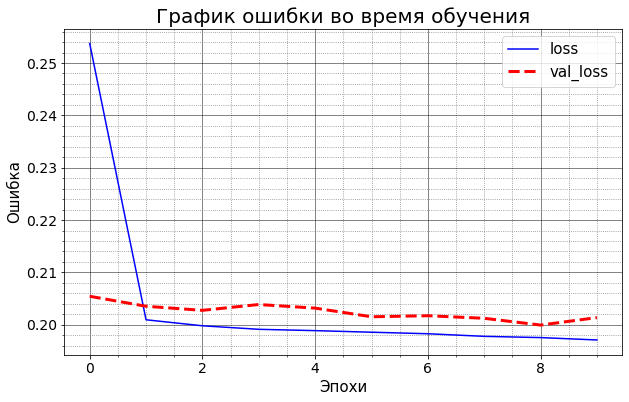

In [56]:
# Вывод графика изменения ошибки

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

plt.plot(history.history['loss'], label='loss',  linewidth=1.5, color='blue')
plt.plot(history.history['val_loss'], linestyle = '--', label='val_loss',  linewidth=3, color='red')

ax.set_title('График ошибки во время обучения', fontsize=20)
ax.set_ylabel('Ошибка', fontsize=15)
ax.set_xlabel('Эпохи', fontsize=15)

#  Устанавливаем форматирование делений:
ax.xaxis.set_tick_params(which = 'major', labelsize = 14)
ax.yaxis.set_tick_params(which = 'major', labelsize = 14)

ax.minorticks_on()
ax.grid(which='major', color = 'k', alpha = 0.6)
ax.grid(which='minor', color = 'gray', linestyle = ':')

ax.legend(fontsize = 15, facecolor = "white", loc = 'upper right')

plt.show()

In [57]:
# тест модели
model.evaluate(X_test, Y_test, batch_size = FIT_batch_size)

19/19 [==============================] - 9s 486ms/step - loss: 0.2048


0.2047632932662964

In [58]:
res = model.predict(X_test)

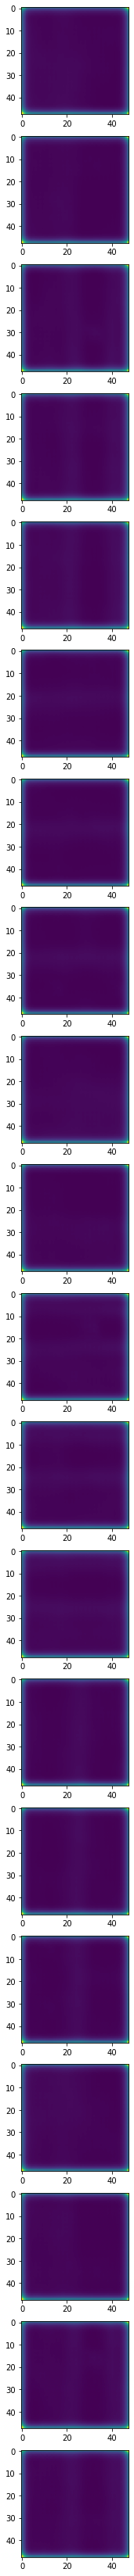

In [59]:
i = 1
fig, axes = plt.subplots(20)

fig.set_figwidth(10)
fig.set_figheight(60)

for ax,rmap in zip(axes,res):
    ax.imshow(rmap)
     
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.8)
plt.show()

In [60]:
res = model.predict(X_dict['run1']['X_time_all'])
Y_res_map = reshape_3D_Y_numpy_to_2D(res,Y_dict['run1']['df'].shape[0],Y_dict['run1']['df'].shape[1],PREP_image_size)
Y_orig_map = reshape_3D_Y_numpy_to_2D(Y_dict['run1']['Y_all'],Y_dict['run1']['df'].shape[0],Y_dict['run1']['df'].shape[1],PREP_image_size)

||||||||||||||||||
Y arr reshaping to 2D
Original arr size:  (27, 48, 48, 1)
Crop windows height/width:  48
New numpy shape:  (144, 432, 1)
||||||||||||||||||

||||||||||||||||||
Y arr reshaping to 2D
Original arr size:  (27, 48, 48, 1)
Crop windows height/width:  48
New numpy shape:  (144, 432, 1)
||||||||||||||||||



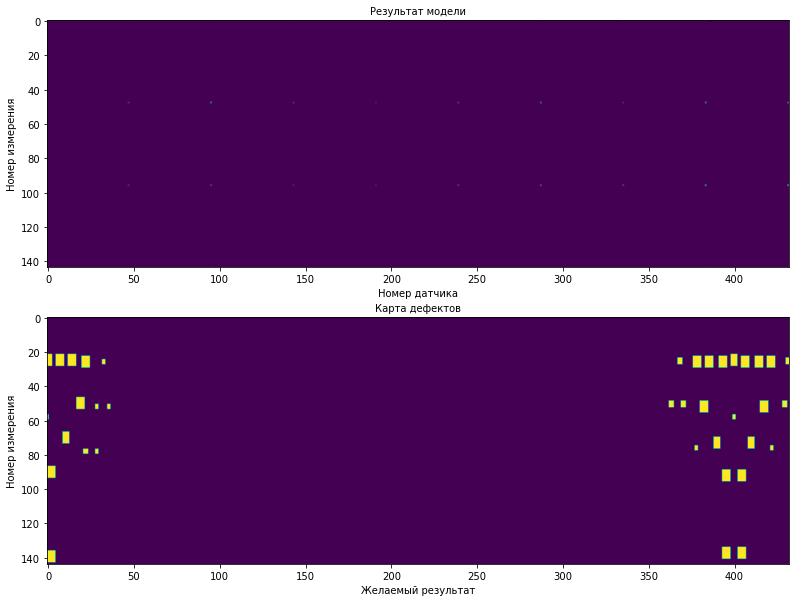

In [61]:
fig, axes = plt.subplots(2)

fig.set_figwidth(20)
fig.set_figheight(10)

axes[0].imshow(Y_res_map)

axes[0].set_xlabel('Номер датчика', fontsize=10) 
axes[0].set_ylabel('Номер измерения', fontsize=10) 
axes[0].set_title('Результат модели', fontsize=10) 

axes[1].imshow(Y_orig_map)

axes[1].set_xlabel('Желаемый результат', fontsize=10) 
axes[1].set_ylabel('Номер измерения', fontsize=10) 
axes[1].set_title('Карта дефектов', fontsize=10) 

     
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.8)
plt.show()

In [62]:
res = model.predict(X_dict['run2']['X_time_all'])
Y_res_map = reshape_3D_Y_numpy_to_2D(res,Y_dict['run2']['df'].shape[0],Y_dict['run2']['df'].shape[1],PREP_image_size)
Y_orig_map = reshape_3D_Y_numpy_to_2D(Y_dict['run2']['Y_all'],Y_dict['run2']['df'].shape[0],Y_dict['run2']['df'].shape[1],PREP_image_size)

||||||||||||||||||
Y arr reshaping to 2D
Original arr size:  (27, 48, 48, 1)
Crop windows height/width:  48
New numpy shape:  (144, 432, 1)
||||||||||||||||||

||||||||||||||||||
Y arr reshaping to 2D
Original arr size:  (27, 48, 48, 1)
Crop windows height/width:  48
New numpy shape:  (144, 432, 1)
||||||||||||||||||



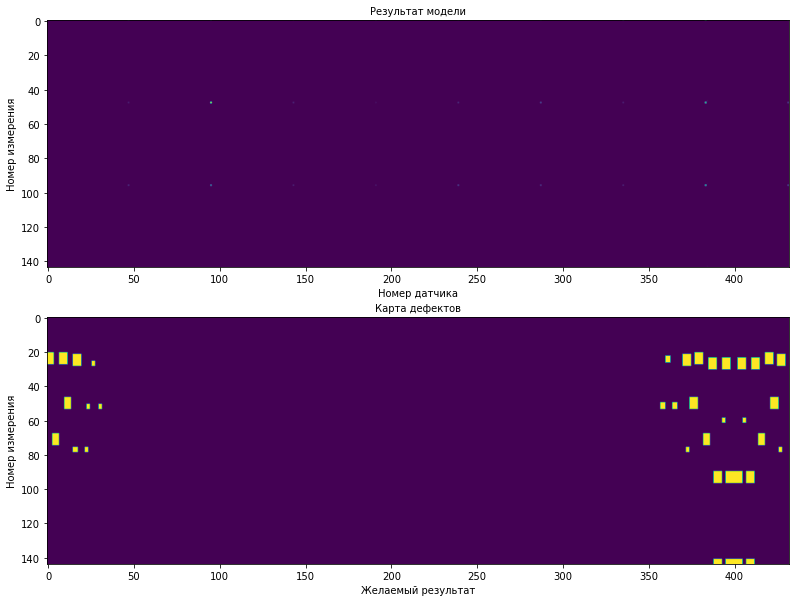

In [63]:
fig, axes = plt.subplots(2)

fig.set_figwidth(20)
fig.set_figheight(10)

axes[0].imshow(Y_res_map)

axes[0].set_xlabel('Номер датчика', fontsize=10) 
axes[0].set_ylabel('Номер измерения', fontsize=10) 
axes[0].set_title('Результат модели', fontsize=10) 

axes[1].imshow(Y_orig_map)

axes[1].set_xlabel('Желаемый результат', fontsize=10) 
axes[1].set_ylabel('Номер измерения', fontsize=10) 
axes[1].set_title('Карта дефектов', fontsize=10) 

     
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.8)
plt.show()